---
## Note from the Teachers:
We added a header with information about your project. 
This is useful since we want to keep a database of all the cool projects participants have made during the courses.
We will save the code in our database and host on github a page to show all the projects. Therefore it is more practical to add some information in the header of each notebook.
Thanks a lot for the understanding and for taking care of it.

You can delete this cell if you want

---

# Project Name: Chess game rating quantification
The idea is to predict, who wins a chess game after some moves. That could be a first step to analyse, which move(s) where the main reason for losing a game or not winning it.

### Project Repo 
link (replace if you have your own repo, otherwise delete)

## Participants:
Niko Schmidt

### Course and Semester
Advanced Deep Learning - from CNN to Transformers
Summer semster 2021

### License

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
\
Further there is absolute no warranty for the provided code.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# import the results
from google.colab import files
uploaded_Results = files.upload()

Saving results_in_numbers.txt.npy to results_in_numbers.txt.npy


In [ ]:
# import the games
from google.colab import files
uploaded_games = files.upload()

Saving game_in_numbers_compressed.txt.npy to game_in_numbers_compressed.txt.npy


In [ ]:
# we use numpy to read the file
my_vector = np.load('game_in_numbers_compressed.txt.npy')
print('text_file shape')
print(np.shape(my_vector))

# We have to decompress the data first
def chess_matrix_decompress(A):
	shapiness = np.shape(A)
	results = np.zeros((shapiness[0],shapiness[1],12,shapiness[2],shapiness[3]))
	for k in range(0,12):
		positions = np.argwhere(A==k)
		for pos in positions:
			results[pos[0],pos[1],k,pos[2],pos[3]] = 1.0

	return results

my_vector = chess_matrix_decompress(my_vector)
print('new shape of data')
print(np.shape(my_vector))

text_file shape
(8, 8, 19, 5000)
new shape of data
(8, 8, 12, 19, 5000)


In [ ]:
my_vector = np.reshape(my_vector,(8*8*12*19,5000))
print('new shape')
print(np.shape(my_vector))

new shape
(14592, 5000)


In [ ]:
my_results = np.load('results_in_numbers.txt.npy')
print('results shape')
print(np.shape(my_results))
print('results')
print(my_results[:,0])

results shape
(5000, 1)
results
[0. 1. 1. ... 0. 0. 0.]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from keras.layers import concatenate
from keras.layers import Bidirectional

from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
# The model is from the backery sales project and adapted to our purpose

In [ ]:
def buildModel2():
  # build the network
  model = Sequential()
  d_rate = 1.0
  reg = 0.0
  model.add(Dense(2048, activation='relu',kernel_regularizer=regularizers.l2(reg), input_shape=(14592,)))
  Dropout(d_rate)
  model.add(Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(512,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  
  print(model.summary())
  return model

In [ ]:
def compileModelAdamMseAcc(buildModel):
  #Compile the model
  #Input: model from buildModel
  #Return: buildModel after compilation
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  buildModel.compile(optimizer = optimizer,
                loss='mae', metrics=['mae'])
  
  return buildModel

In [ ]:
def fitModel(xTrain, yTrain, xVal, yVal, trainingEpochs, compiledModel):
  #Fit the model
  #Input: compiled Model, Train and Validation Data, Batch Size and trainingEpochs
  #Return: history and model
  history = compiledModel.fit(xTrain, yTrain,batch_size=1024, epochs = trainingEpochs, validation_data=(xVal, yVal))

  return history


In [ ]:
def fitModelLearningRateTuner(xTrain, yTrain, xVal, yVal, trainingEpochs, compiledModel):
  #Fit the model
  #Input: compiled Model, Train and Validation Data, Batch Size and trainingEpochs
  #Return: history and model
  optimizer = tf.keras.optimizers.Adam(lr=1e-6)
  compiledModel.compile(optimizer = optimizer,
                loss='mae', metrics=['mae'])
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

  history = compiledModel.fit(xTrain, yTrain,batch_size=1024, epochs = trainingEpochs,callbacks=[lr_schedule])

  return history

In [ ]:
def trainDevTestSplit(X, Y, testSize, randomSeed):
  #Splits by test size into Train / Dev
  #Splits dev then 50/50 into dev and Test

  xTrain, xDev, yTrain, yDev = train_test_split(X, Y, test_size=testSize, random_state=randomSeed)

  xTest = xDev[:len(xDev)//2]
  yTest = yDev[:len(yDev)//2]
  
  xDev = xDev[len(xDev)//2:]
  yDev = yDev[len(yDev)//2:]
  #xDev, yDev, xTest, yTest = train_test_split(xDev, yDev, test_size =0.5, random_state = randomSeed)

  return xTrain, yTrain, xDev, yDev, xTest, yTest

In [ ]:
xTrain, yTrain, xDev, yDev, xTest, yTest = trainDevTestSplit(np.transpose(my_vector),my_results, 0.10, 42)

In [ ]:
print(len(xTrain))
print(len(xTest))
print(len(xDev))

4500
250
250


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 2048)              29886464  
_________________________________________________________________
dense_45 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_46 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_47 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_48 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 64)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5/5 [==============================] - 2s 67ms/step - loss: 0.4843 - mae: 0.4843
Epoch 2/200
5/5 [==============================] - 0s 54ms/step - loss: 0.4837 - mae: 0.4837
Epoch 3/200
5/5 [==============================] - 0s 54ms/step - loss: 0.4840 - mae: 0.4840
Epoch 4/200
5/5 [==============================] - 0s 53ms/step - loss: 0.4843 - mae: 0.4843
Epoch 5/200
5/5 [==============================] - 0s 53ms/step - loss: 0.4837 - mae: 0.4837
Epoch 6/200
5/5 [==============================] - 0s 51ms/step - loss: 0.4846 - mae: 0.4846
Epoch 7/200
5/5 [==============================] - 0s 52ms/step - loss: 0.4845 - mae: 0.4845
Epoch 8/200
5/5 [==============================] - 0s 54ms/step - loss: 0.4830 - mae: 0.4830
Epoch 9/200
5/5 [==============================] - 0s 54ms/step - loss: 0.4833 - mae: 0.4833
Epoch 10/200
5/5 [==============================] - 0s 54ms/step - loss: 0.4837 - mae: 0.4837
Epoch 11/200
5/5 [==============================] - 0s 55ms/step - loss: 0.4820 -

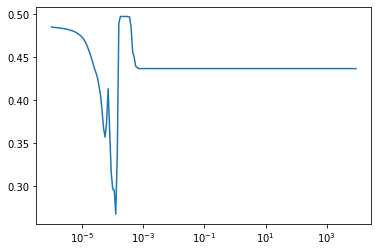

In [ ]:
modelLrTune = buildModel2()
history = fitModelLearningRateTuner(xTrain, yTrain, xDev, yDev, 200, modelLrTune)
plt.semilogx(history.history["lr"], history.history["loss"])

In [ ]:
#Fit Model with tuned Learning Rate
model = buildModel2()
model = compileModelAdamMseAcc(model)
hist = fitModel(xTrain, yTrain, xDev, yDev, 20, model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 2048)              29886464  
_________________________________________________________________
dense_56 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_57 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_59 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_60 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_61 (Dense)             (None, 64)               

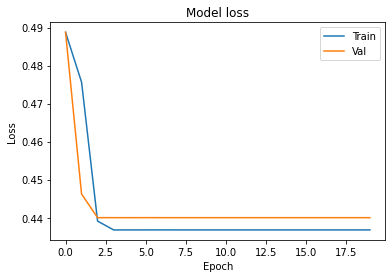

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
#Predict the test set
predictions = model.predict(xTest)
print("predictions shape:", predictions.shape)
# We now change it to 0 0.5 and 1.
for k in range(len(predictions)):
  if(predictions[k]<0.25):
    predictions[k] = 0.0
  elif(predictions[k]>0.75):
    predictions[k] = 1.0
  else:
    predictions[k] = 0.5

predictions shape: (250, 1)


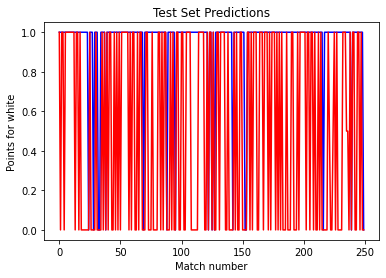

In [ ]:
plt.plot(predictions,color='blue')
plt.plot(yTest,color='red')
plt.title('Test Set Predictions')
plt.ylabel('Points for white')
plt.xlabel('Match number')
#plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
# We use a simple comparision with draw every round
mae = tf.keras.losses.MeanAbsoluteError()
compare = np.ones((250,1))*0.5
print('error simple approach')
print(mae(compare,yTest))
print('error corrected predictions')
print(mae(predictions,yTest))

error simple approach
tf.Tensor(0.492000013589859, shape=(), dtype=float64)
error corrected predictions
tf.Tensor(0.4399999976158142, shape=(), dtype=float64)
